In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math

import os
import sys
from numpy.fft import fft, ifft
import glob

In [1]:
def remove_periodic(X, df_index, detrending=True, model='additive', frequency_threshold=0.1e12):
    rad = np.array(X)
    
    if detrending:
        det_rad = rad - np.average(rad)
    else:
        det_rad = rad
    
    det_rad_fft = fft(det_rad)

    # Get the power spectrum
    rad_ps = [np.abs(rd)**2 for rd in det_rad_fft]
    
    clean_rad_fft = [det_rad_fft[i] if rad_ps[i] > frequency_threshold else 0 
                     for i in range(len(det_rad_fft))]
    
    rad_series_clean = ifft(clean_rad_fft)
    rad_series_clean = [value.real for value in rad_series_clean]
    
    if detrending:
        rad_trends = rad_series_clean + np.average(rad)
    else:
        rad_trends = rad_series_clean
        
    rad_clean_ts = pd.Series(rad_trends, index=df_index)
    
    #rad_clean_ts[(rad_clean_ts.index.hour < 6) | (rad_clean_ts.index.hour > 20)] = 0
    residual = rad - rad_clean_ts.values
    clean = rad_clean_ts.values
    return residual, clean

In [3]:
def normalized_rmse(targets, forecasts):
    if isinstance(targets, list):
        targets = np.array(targets)
    if isinstance(forecasts, list):
        forecasts = np.array(forecasts)
    return ((np.sqrt(np.nanmean((targets - forecasts) ** 2))) / np.nanmean(targets) ) * 100

In [4]:
def load_data(path, resampling=None):
    ## some resampling options: 'H' - hourly, '15min' - 15 minutes, 'M' - montlhy
    ## more options at:
    ## http://benalexkeen.com/resampling-time-series-data-with-pandas/
    allFiles = glob.iglob(path + "/**/*.txt", recursive=True)
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        #print("Reading: ",file_)
        df = pd.read_csv(file_,index_col="datetime",parse_dates=['datetime'], header=0, sep=",")
        if frame.columns is None :
            frame.columns = df.columns
        list_.append(df)
    frame = pd.concat(list_)
    if resampling is not None:
        frame = frame.resample(resampling).mean()
    frame = frame.fillna(method='ffill')
    return frame

In [5]:
path = '/Users/cseveriano/spatio-temporal-forecasting/data/processed/NREL/Oahu'

df = load_data(path)

# Corrigir ordem das colunas
df.columns = ['DHHL_3','DHHL_4', 'DHHL_5', 'DHHL_10', 'DHHL_11', 'DHHL_9', 'DHHL_2', 'DHHL_1', 'DHHL_1_Tilt', 'AP_6', 'AP_6_Tilt', 'AP_1', 'AP_3', 'AP_5', 'AP_4', 'AP_7', 'DHHL_6', 'DHHL_7', 'DHHL_8']

In [6]:
#inicio dos dados possui falhas na medicao
df = df.loc[df.index > '2010-03-20']

## Preparação dos dados

In [7]:
clean_df = pd.DataFrame(columns=df.columns, index=df.index)
residual_df = pd.DataFrame(columns=df.columns, index=df.index)

for col in df.columns:
    residual, clean = remove_periodic(df[col].tolist(), df.index, frequency_threshold=0.01e12)
    clean_df[col] = clean.tolist()
    residual_df[col] = residual.tolist()

In [8]:
train_df = df[(df.index >= '2010-09-01') & (df.index <= '2011-09-01')]
train_clean_df = clean_df[(clean_df.index >= '2010-09-01') & (clean_df.index <= '2011-09-01')]
train_residual_df = residual_df[(residual_df.index >= '2010-09-01') & (residual_df.index <= '2011-09-01')]


test_df = df[(df.index >= '2010-08-05')& (df.index < '2010-08-06')]
test_clean_df = clean_df[(clean_df.index >= '2010-08-05')& (clean_df.index < '2010-08-06')]
test_residual_df = residual_df[(residual_df.index >= '2010-08-05')& (residual_df.index < '2010-08-06')]

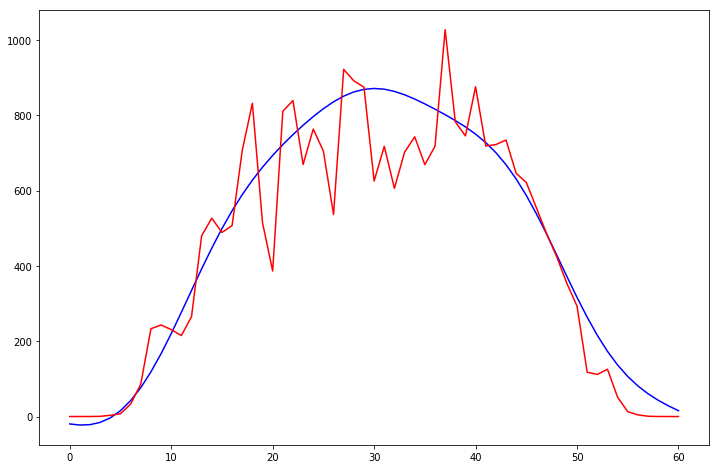

In [9]:
fig = plt.figure(figsize=(12, 8))
plt.plot(test_clean_df.DHHL_3.values, color='blue')
plt.plot(test_df.DHHL_3.values, color='red')
plt.show()

## Fuzzy C-Means

In [ ]:
from pyFTS.partitioners import FCM